In [1]:
from analysis import iso_in_plots, aesthetic_plot, PRAnalysis
from betaplus import SB, MB
import fitPRd

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

import cProfile
profiler = cProfile.Profile()

# Get 3D aPSF-kernel

## Numpy CPU single-core implementation 

In [ ]:
def aPSF3D_sb(_r, _a, _b, _c, _n):
    eps = 1e-4 #mm
    _r = np.where(_r < eps, eps, _r)

    f = (_a*_r)**_n + (_b*_r)**2.5 + (_c*_r)**3.5
    df = (_n*_a*(_a*_r)**(_n-1) + 2.5*_b*(_b*_r)**1.5 + 3.5*_c*(_c*_r)**2.5)

    aPSF3D = df * np.exp(-f) / _r**2
    return aPSF3D

def VG(dist_aPSF3D, STEP, SIZE, rlim, voxel_griding=10, source_griding=11):
    """
    Performs voxel gridding (VG) to compute a 3D PSF kernel.

    Parameters:
        dist_aPSF3D (function): Function that calculates the PSF value given a distance r
        STEP (list): Voxel dimensions in cm [dx, dy, dz] in mm
        SIZE (list): Kernel size in voxels [nx, ny, nz]
        rlim (tuple): (rmin, rmax) Range of distances to consider in mm
        voxel_griding (int): Number of samples within each voxel
        source_griding (int): Number of samples within the source voxel

    Returns:
        numpy.ndarray: Normalized 3D PSF kernel
    """
    if voxel_griding % 2 == 0:
        voxel_griding += 1  # Ensure voxel_griding is odd
        print("voxel_griding is changed to", voxel_griding)
    if source_griding % 2 == 0:
        source_griding += 1
        print("source_griding is changed to", source_griding)
    if len(STEP) != 3 or len(SIZE) != 3:
        raise ValueError("STEP and SIZE must be lists of length 3.")
    if len(rlim) != 2:
        raise ValueError("rlim must be a tuple of length 2.")
    
    STEP = [s*10 for s in STEP]  # Convert to mm

    rmin, rmax = rlim
    rmin = max(rmin, 1e-4)  # Ensure rmin is not zero
    RMAX = 3**0.5 * max(STEP)*max(SIZE)/2
    rmax = RMAX if rmax is None or rmax > RMAX else rmax    # Ensure rmax is within reasonable bounds

    dx, dy, dz = STEP
    nx, ny, nz = SIZE
    aPSF_kernel = np.zeros((nx, ny, nz), dtype=np.float32)

    # Check size is odd
    if nx % 2 == 0 or ny % 2 == 0 or nz % 2 == 0:
        raise ValueError("Kernel sizes must be odd to properly place the source voxel.")

    # Load iterators to save memory
    voxel_indices = itertools.product(range(nx), range(ny), range(nz))
    voxel_centers = itertools.starmap(lambda ix, iy, iz: ((ix-nx//2)*dx, (iy-ny//2)*dy, (iz-nz//2)*dz), voxel_indices)

    # Grid points in source voxel
    grid_source = [np.linspace(0, step/2, 1+source_griding//2) for step in STEP]  # Only positive to always start at 0
    grid_source = [np.sort(np.concat((-g[1:], +g), dtype=np.float32)) for g in grid_source]         # Include negative values

    # Loop over all voxels in kernel and grid them
    for (ix,iy,iz), (cx,cy,cz) in tqdm(zip(voxel_indices, voxel_centers), total=nx*ny*nz//2):
      grid_xyz = np.linspace((cx-dx/2, cy-dy/2, cz-dz/2), (cx+dx/2, cy+dy/2, cz+dz/2), voxel_griding)
      x,y,z = np.meshgrid(grid_xyz[:, 0], grid_xyz[:, 1], grid_xyz[:, 2], indexing='ij')

      # Loop over all sampled source points and eval aPSF3D(r)
      for (sx, sy, sz) in itertools.product(*grid_source):
        r = np.sqrt((x-sx)**2 + (y-sy)**2 + (z-sz)**2)
        r = np.where(r < rmin, rmin, r)
        mask = (r <= rmax)
        psf = dist_aPSF3D(r) * mask
        aPSF_kernel[ix, iy, iz] += psf.sum()

    aPSF_kernel /= aPSF_kernel.sum()    
    return aPSF_kernel

a,b,c,n = 0.312,  0.233,  0.121,  1.106
aPSF3D = lambda r: aPSF3D_sb(r, a, b, c, n)


SIZE = [21]*3  # kernel size
STEP = [0.1]*3  # voxel size in cm
aPSF_kernel_VG = VG(aPSF3D, STEP, SIZE, rlim=(5e-6, 2), voxel_griding=13, source_griding=1)
# aPSF_kernel_VG[aPSF_kernel_VG > 3e-3] = 3e-3

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(np.sum(aPSF_kernel_VG, axis=2))
plt.xlabel("x (voxel)")
plt.ylabel("y (voxel)")
plt.colorbar()

plt.subplot(122)
plt.plot(np.sum(aPSF_kernel_VG, axis=(1, 2)))
plt.show()

## PyTorch GPU implementation

In [ ]:
# import torch


# def aPSF3D_sb(_r, _a, _b, _c, _n):
#     eps = 1e-4 #mm
#     _r = torch.where(_r < eps, eps, _r)

#     f = (_a*_r)**_n + (_b*_r)**2.5 + (_c*_r)**3.5
#     df = (_n*_a*(_a*_r)**(_n-1) + 2.5*_b*(_b*_r)**1.5 + 3.5*_c*(_c*_r)**2.5)

#     aPSF3D = df * torch.exp(-f) / _r**2
#     return aPSF3D

# def VG(dist_aPSF3D, STEP, SIZE, rlim, voxel_griding=11, source_griding=1):
#     """ dist(r), STEP and rlim in mm """
#     if voxel_griding % 2 == 0:
#         voxel_griding += 1  # Ensure voxel_griding is odd
#         print("voxel_griding is changed to", voxel_griding)

#     rmin, rmax = rlim
#     rmin = max(rmin, 1e-6)  # Ensure rmin is not zero
#     RMAX = 3**0.5 * max(STEP)*max(SIZE)/2
#     rmax = RMAX if rmax is None or rmax > RMAX else rmax    # Ensure rmax is within reasonable bounds 
#     dx, dy, dz = STEP
#     nx, ny, nz = SIZE
#     aPSF_kernel = torch.zeros((nx, ny, nz)).to(device)

#     # Check size is odd
#     if nx % 2 == 0 or ny % 2 == 0 or nz % 2 == 0:
#         raise ValueError("Kernel sizes must be odd to properly place the source voxel.")

#     # Sample a full 3D grid of points within the center voxel
#     voxel_indices = itertools.product(range(nx), range(ny), range(nz))
#     voxel_centers = itertools.starmap(lambda ix, iy, iz: ((ix-nx//2)*dx, (iy-ny//2)*dy, (iz-nz//2)*dz), voxel_indices)

#     grid_source = [np.linspace(0, step/2, 1+source_griding//2) for step in STEP]  # Only positive to always start at 0
#     grid_source = [np.sort(np.concat((-g[1:], +g))) for g in grid_source]         # Include negative values

#     for (ix,iy,iz), (cx,cy,cz) in tqdm(zip(voxel_indices, voxel_centers), total=nx*ny*nz//2):
#       x = torch.linspace(cx-dx/2, cx+dx/2, voxel_griding)
#       y = torch.linspace(cy-dy/2, cy+dy/2, voxel_griding)
#       z = torch.linspace(cz-dz/2, cz+dz/2, voxel_griding)
#       xx,yy,zz = torch.meshgrid(x, y, z, indexing='ij')

#       for (sx, sy, sz) in itertools.product(*grid_source):
#         r = torch.sqrt((xx-sx)**2 + (yy-sy)**2 + (zz-sz)**2).to(device)
#         mask = (r >= rmin) & (r <= rmax)
#         psf = dist_aPSF3D(r) * mask
#         aPSF_kernel[ix, iy, iz] += psf.sum()

#     # aPSF_kernel /= aPSF_kernel.sum()    
#     return aPSF_kernel

# a,b,c,n = 0.312,  0.233,  0.121,  1.106
# aPSF3D = lambda r: aPSF3D_sb(r, a, b, c, n)


# SIZE = [21]*3  # kernel size
# STEP = [0.1]*3  # voxel size in mm
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# profiler.enable()
# aPSF_kernel_VG = VG(aPSF3D, STEP, SIZE, rlim=(1e-6, 2), voxel_griding=13, source_griding=5)
# profiler.disable()
# # profiler.print_stats(sort='tottime')
# aPSF_kernel_VG = aPSF_kernel_VG.cpu().numpy()

# plt.figure(figsize=(15, 5))

# plt.subplot(121)
# plt.imshow(np.sum(aPSF_kernel_VG, axis=2))
# plt.xlabel("x (voxel)")
# plt.ylabel("y (voxel)")
# plt.colorbar()

# plt.subplot(122)
# plt.plot(np.sum(aPSF_kernel_VG, axis=(1, 2)))
# plt.show()

# Compare with kernel from simulation

Isotope: F18
	Maximum kernel PR in x-axis: 10.25 mm
	Maximum simulated PR: 2.50 mm
	90% yield simulated PR: 0.79 mm


100%|██████████| 34460/34460 [00:07<00:00, 4648.30it/s]


	R2: 0.9055
Isotope: Ga68
	Maximum kernel PR in x-axis: 10.25 mm
	Maximum simulated PR: 9.55 mm
	90% yield simulated PR: 4.45 mm


100%|██████████| 34460/34460 [00:08<00:00, 4059.63it/s]


	R2: 0.9924
Isotope: Rb82
	Maximum kernel PR in x-axis: 10.25 mm
	Maximum simulated PR: 16.86 mm
	90% yield simulated PR: 9.03 mm


100%|██████████| 34460/34460 [00:08<00:00, 3974.96it/s]


	R2: 0.9983


100%|██████████| 34460/34460 [02:00<00:00, 285.50it/s]


Maximum deviation considering S=3: 4.92%
Minimum deviation considering S=3: -2.58%


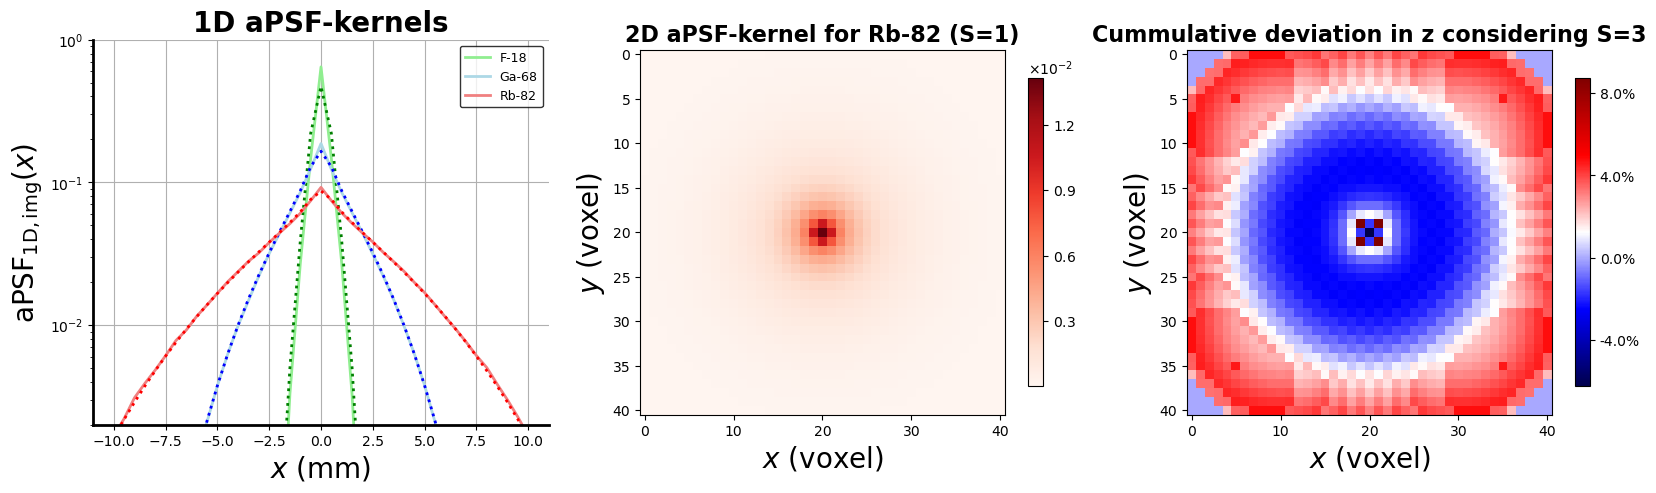

In [13]:
def get_params(_iso, _fitFile):
    _params = []
    with open(_fitFile, "r") as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith(_iso):
                _params = [float(x) for x in line.split()[4:]]
                break
    return _params

def VG(dist_aPSF3D, STEP, SIZE, rlim, voxel_griding=10, source_griding=11):
    """
    Performs voxel gridding (VG) to compute a 3D PSF kernel.

    Parameters:
        dist_aPSF3D (function): Function that calculates the PSF value given a distance r
        STEP (list): Voxel dimensions in cm [dx, dy, dz] in mm
        SIZE (list): Kernel size in voxels [nx, ny, nz]
        rlim (tuple): (rmin, rmax) Range of distances to consider in mm
        voxel_griding (int): Number of samples within each voxel
        source_griding (int): Number of samples within the source voxel

    Returns:
        numpy.ndarray: Normalized 3D PSF kernel
    """
    if voxel_griding % 2 == 0:
        voxel_griding += 1  # Ensure voxel_griding is odd
        print("voxel_griding is changed to", voxel_griding)
    if source_griding % 2 == 0:
        source_griding += 1
        print("source_griding is changed to", source_griding)
    if len(STEP) != 3 or len(SIZE) != 3:
        raise ValueError("STEP and SIZE must be lists of length 3.")
    if len(rlim) != 2:
        raise ValueError("rlim must be a tuple of length 2.")
    
    STEP = [s*10 for s in STEP]  # Convert to mm

    rmin, rmax = rlim
    rmin = max(rmin, 1e-8)  # Ensure rmin is not zero
    RMAX = 3**0.5 * max(STEP)*max(SIZE)/2
    rmax = RMAX if rmax is None or rmax > RMAX else rmax    # Ensure rmax is within reasonable bounds

    dx, dy, dz = STEP
    nx, ny, nz = SIZE
    aPSF_kernel = np.zeros((nx, ny, nz), dtype=np.float32)

    # Check size is odd
    if nx % 2 == 0 or ny % 2 == 0 or nz % 2 == 0:
        raise ValueError("Kernel sizes must be odd to properly place the source voxel.")

    # Load iterators to save memory
    voxel_indices = itertools.product(range(nx), range(ny), range(nz))
    voxel_centers = itertools.starmap(lambda ix, iy, iz: ((ix-nx//2)*dx, (iy-ny//2)*dy, (iz-nz//2)*dz), voxel_indices)

    # Grid points in source voxel
    grid_source = [np.linspace(0, step/2, 1+source_griding//2) for step in STEP]  # Only positive to always start at 0
    grid_source = [np.sort(np.concat((-g[1:], +g), dtype=np.float32)) for g in grid_source]         # Include negative values

    # Loop over all voxels in kernel and grid them
    for (ix,iy,iz), (cx,cy,cz) in tqdm(zip(voxel_indices, voxel_centers), total=nx*ny*nz//2):
      grid_xyz = np.linspace((cx-dx/2, cy-dy/2, cz-dz/2), (cx+dx/2, cy+dy/2, cz+dz/2), voxel_griding)
      x,y,z = np.meshgrid(grid_xyz[:, 0], grid_xyz[:, 1], grid_xyz[:, 2], indexing='ij')

      # Loop over all sampled source points and eval aPSF3D(r)
      for (sx, sy, sz) in itertools.product(*grid_source):
        r = np.sqrt((x-sx)**2 + (y-sy)**2 + (z-sz)**2)
        mask = (r >= rmin) & (r <= rmax)
        psf = dist_aPSF3D(r) * mask
        aPSF_kernel[ix, iy, iz] += psf.sum()

    aPSF_kernel /= aPSF_kernel.sum()    
    return aPSF_kernel

def R2(x, y):
    """
    Calculate the R-squared value between two datasets.

    Parameters:
        x (numpy.ndarray): First dataset
        y (numpy.ndarray): Second dataset

    Returns:
        float: R-squared value
    """
    x = np.array(x)
    y = np.array(y)
    if len(x) != len(y):
        raise ValueError("Input arrays must have the same length.")
    
    ss_res = np.sum((x - y)**2)
    ss_tot = np.sum((x - np.mean(x))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

pfolder = "PenEasy2024_xyz"
fitFile_preffix = "SPC"
fitFile_suffix = "n_is_param"
kernel_size = [41]*3
kernel_step = [5e-1/10]*3 # voxel size in cm

colors1 = ['g', 'b', 'r', 'c', 'm']
colors2 = ['lightgreen', 'lightblue', 'lightcoral', 'paleturquoise', 'violet']
colors = list(zip(colors1, colors2))
isotopes = ["F18", "Ga68", "Rb82"]
iso_colors = dict(zip(isotopes, colors))

plt.figure(figsize=(20, 5))
for iso in isotopes:
    data_file = f"RESULTS/SPC/Water/{pfolder}/{iso}.dat"
    simul_data = PRAnalysis(f"{iso} {pfolder}", data_file, SIZE=kernel_size, STEP=kernel_step) 
    xdata = simul_data.xp*10
    real_aPSFx = simul_data.aPSFx

    print(f"Isotope: {iso}")
    print(f"\tMaximum kernel PR in x-axis: {simul_data.Xmax*10:.2f} mm")
    print(f"\tMaximum simulated PR: {simul_data.rmax*10:.2f} mm")
    print(f"\t90% yield simulated PR: {simul_data.interpol_G3D(0.9)*10:.2f} mm")

    # Get fitting parameters
    if iso in SB.keys():
        fit_file = f"RESULTS/SPC/Water/{pfolder}/{fitFile_preffix}-sb_fit-{fitFile_suffix}.txt"
        fit_func, argsP, argsC = fitPRd.MBfit_function(100)
        params = get_params(iso, fit_file)

    elif iso in MB.keys():
        fit_file = f"RESULTS/MB/Water/{pfolder}/{fitFile_preffix}-mb_fit-{fitFile_suffix}.txt"
        weights = [b[3]*100 for b in MB[iso]['branches']]
        fit_func, argsP, argsC = fitPRd.MBfit_function(*weights)
        params = []
        for i in range(len(weights)):
            isob = f"{iso}-b{i+1}"
            params += get_params(isob, fit_file)

    fit_func.fitted_params = params
    aPSF3D_tmp = fit_func.get_aPSF3D()
    aPSF3D = lambda _r: aPSF3D_tmp(np.where(_r < 1e-6, 1e-6, _r))
    aPSF_kernel_VG = VG(aPSF3D, kernel_step, kernel_size, rlim=(1e-6, None), voxel_griding=5, source_griding=1)

    plt.subplot(131)
    aPSFx_sin_kernel = np.sum(aPSF_kernel_VG, axis=(1, 2))
    aPSFx_sin_kernel /= aPSFx_sin_kernel.sum()
    plt.plot(simul_data.aPSFx_range*10, real_aPSFx/real_aPSFx.sum(), '-', label=f"{iso_in_plots(iso)}", color=iso_colors[iso][1])
    plt.plot(simul_data.aPSFx_range*10, aPSFx_sin_kernel, ':', color=iso_colors[iso][0])
    print(f"\tR2: {R2(real_aPSFx/real_aPSFx.sum(), aPSFx_sin_kernel):.4f}")
plt.xlabel(r"$x$ (mm)")
plt.ylabel(r"$\mathrm{aPSF}_\mathrm{1D,img}(x)$")
plt.title("1D aPSF-kernels", fontsize=16, fontweight='bold')
plt.yscale('log')
plt.ylim(2e-3, 1)
aesthetic_plot()

import matplotlib.ticker as mticker
plt.subplot(132)
plt.imshow(np.sum(aPSF_kernel_VG, axis=2), cmap='Reds', interpolation='nearest')
plt.xlabel(r"$x$ (voxel)", fontsize=20)
plt.ylabel(r"$y$ (voxel)", fontsize=20)
cbar = plt.colorbar(shrink=0.8)
cbar.locator = mticker.MaxNLocator(nbins=5)
cbar.update_ticks()
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.set_major_formatter(formatter)
cbar.ax.yaxis.set_offset_position('left')
plt.title(f"2D aPSF-kernel for {iso_in_plots(iso)} (S=1)", fontsize=16, fontweight='bold')

plt.subplot(133)
aPSF_kernel_VG_S3 = VG(aPSF3D, kernel_step, kernel_size, rlim=(1e-6, None), voxel_griding=5, source_griding=3)
dev = (aPSF_kernel_VG_S3 - aPSF_kernel_VG) / aPSF_kernel_VG * 100
mask = (aPSF_kernel_VG < 1e-6)
dev[mask] = 0
maxdev = np.max(dev)
mindev = np.min(dev)
print(f"Maximum deviation considering S=3: {maxdev:.2f}%")
print(f"Minimum deviation considering S=3: {mindev:.2f}%")

plt.imshow(np.sum(dev, axis=2), cmap='seismic', interpolation='nearest')
plt.xlabel(r"$x$ (voxel)", fontsize=20)
plt.ylabel(r"$y$ (voxel)", fontsize=20)
cbar = plt.colorbar(shrink=0.8)
cbar.locator = mticker.MaxNLocator(nbins=5, symmetric=True)
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}%"))
plt.title(f"Cummulative deviation in z considering S=3", fontsize=16, fontweight='bold')
plt.show()

In [12]:
dev = (aPSF_kernel_VG_S3 - aPSF_kernel_VG) / aPSF_kernel_VG * 100
dev[mask] = 0
dev[19:22, 19:22, 19:22]
# np.where(dev==mindev)

array([[[ 0.       ,  4.9166684,  0.       ],
        [-2.5785456,  0.       ,  1.2795937],
        [ 0.       ,  4.9166684,  0.       ]],

       [[-2.5785456,  0.       ,  1.2795937],
        [ 0.       , -2.5785456,  0.       ],
        [-2.5785456,  0.       ,  1.2795937]],

       [[ 0.       ,  4.9166784,  0.       ],
        [-2.5785544,  0.       ,  1.2795937],
        [ 0.       ,  4.9166684,  0.       ]]], dtype=float32)